### 抓取行政边界坐标点
#### 高德API：
https://lbs.amap.com/api/webservice/guide/api/district  
* (1)keywords = 上海  
规则：只支持单个关键词语搜索关键词支持：行政区名称、citycode、adcode
例如，在subdistrict=2，搜索省份（例如山东），能够显示市（例如济南），区（例如历下区）

* (2)subdistrict = 3  
规则：设置显示下级行政区级数（行政区级别包括：国家、省/直辖市、市、区/县4个级别）
可选值：0、1、2、3
0：不返回下级行政区；
1：返回下一级行政区；
2：返回下两级行政区；
3：返回下三级行政区；

* (3)extensions = all  
此项控制行政区信息中返回行政区边界坐标点； 可选值：base、all;
base:不返回行政区边界坐标点；
all:只返回当前查询district的边界值，不返回子节点的边界值；

* (4)返回polyline 行政区边界坐标点  
当一个行政区范围，由完全分隔两块或者多块的地块组成，每块地的 polyline 坐标串以 | 分隔 。

#### 参考文章网址：
http://zhaoxuhui.top/blog/2017/07/20/%E8%8E%B7%E5%8F%96%E8%A1%8C%E6%94%BF%E5%8C%BA%E8%BE%B9%E7%95%8C%E5%92%8C%E5%88%A9%E7%94%A8GDAL%E7%94%9F%E6%88%90shp%E6%96%87%E4%BB%B6.html

https://www.cnblogs.com/ITGIS/p/3542601.html

#### 修正原文中没有设置参考坐标系  
* 添加wgs84坐标系：   https://blog.csdn.net/theonegis/article/details/80554993  
* 添加投影：   http://geopandas.org/projections.html
* 多个面合并成为一个文件（ogr资料）  https://pcjericks.github.io/py-gdalogr-cookbook/geometry.html#create-a-linestring
* 增加code等信息

#### 其他资料
https://stackoverflow.com/questions/13198391/create-a-shape-file

https://blog.csdn.net/sinat_29675423/article/details/87434839

https://pcjericks.github.io/py-gdalogr-cookbook/geometry.html#create-a-multipoint

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import urllib
import json
import gdal
import ogr
import osr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Get_Administrative_Boundary():
    def __init__(self, key, keywords, filename):
        self.key = key
        self.keywords = keywords
        self.filename = filename     
        
    def get_boundary(self, key, keywords):
#         key = '2ec800bea308e094ad206a582f87e206'
        subdistrict = 3
        extensions = 'all'
        params = {'key': key,
                 'keywords': keywords,
                 'subdistrict': 3,
                 'extensions': 'all'}
        url = 'https://restapi.amap.com/v3/config/district?'
        request = url + urllib.parse.urlencode(params)
        response = urllib.request.urlopen(request)
        web_data = response.read()
        data = json.loads(web_data)
        
        # 解析data， 提取相关元素
        elements = data['districts'][0]
        self.citycode = elements['citycode']  # 城市编号
        if self.citycode == []: self.citycode = 'NAN'
        self.adcode = elements['adcode']  # 区域编号
        self.name = elements['name']   # 行政区名称
        self.polyline = elements['polyline']   # 行政区边界坐标点
        self.center = elements['center']   # 城市中心点
        self.level = elements['level']   # 行政区划级别
#         districts = elements['districts']

        num = self.polyline.split('|').__len__()
        print('{}存在{}块'.format(keywords, num))

        blocks = self.polyline.split('|')  # 当包含多块地的时切分成至少两块；当只有一块地时无影响

        polylines = []
        str_polylines = []
        for item in blocks:
            line = item.split(';')
            polylines.append(line)

        # 依次遍历每一条多段线，拼接对应格式的字符串
        for line in polylines:
            list_lat = []
            list_lon = []
            for item in line:
                res = item.split(',')
                list_lon.append(res[0])
                list_lat.append(res[1])
            result_str = ''
            # print(list_lat.__len__(), "points are read.")
            for i in range(list_lat.__len__()):
                result_str += list_lon[i] + " " + list_lat[i] + ","
            result_str = "POLYGON ((" + result_str[:-1] + "))"
            str_polylines.append(result_str)
        return num, str_polylines
    
    def write_vector_file(self, filename, content):
        # 单块文件
        # 为了支持中文路径，添加下面这句代码
        gdal.SetConfigOption("GDAL_FILENAME_IS_UTF8", "NO")
        # 为了使属性表字段支持中文，添加下面这句
        gdal.SetConfigOption("SHAPE_ENCODING", "")
        # 注册所有的驱动
        ogr.RegisterAll()

        # 创建数据
        strDriverName = "ESRI Shapefile"
        oDriver = ogr.GetDriverByName(strDriverName)
        if oDriver is None: print(strDriverName, "驱动不可用")

        # 创建WGS84空间参考
        srs = osr.SpatialReference()
        srs.ImportFromEPSG(4326)
        srs.ImportFromProj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

        # 创建数据源
        oDS = oDriver.CreateDataSource(filename)
        if oDS == None: print(filename, "创建文件失败！")

        # 创建图层，创建一个多边形图层，这里没有指定空间参考，如果需要的话，需要在这里进行指定
        papszLCO = []
        oLayer = oDS.CreateLayer("Polygon", srs, ogr.wkbPolygon, papszLCO)
        if oLayer == None: print("图层创建失败！\n")

        # 下面创建属性表
        # 先创建一个叫FieldID的整型属性
        oFieldID = ogr.FieldDefn("FieldID", ogr.OFTInteger)
        oLayer.CreateField(oFieldID, 1)

        # 再创建一个叫FeatureName的字符型属性，字符长度为50
        oFieldName = ogr.FieldDefn("FieldName", ogr.OFTString)
        oFieldName.SetWidth(100)
        oLayer.CreateField(oFieldName, 1)

        # 创建城市编号等元素
        oFieldNAME = ogr.FieldDefn('name', ogr.OFTString)
        oLayer.CreateField(oFieldNAME,1)

        oFieldCityCode = ogr.FieldDefn('citycode', ogr.OFTString)
        oLayer.CreateField(oFieldCityCode,1)

        oFieldAdCode = ogr.FieldDefn('adcode', ogr.OFTString)
        oLayer.CreateField(oFieldAdCode,1)

        oFieldCenter = ogr.FieldDefn('center',ogr.OFTString)
        oLayer.CreateField(oFieldCenter, 1)

        oFieldLevel = ogr.FieldDefn('level',ogr.OFTString)
        oLayer.CreateField(oFieldLevel, 1)

        oDefn = oLayer.GetLayerDefn()

        for item in content:
            # 创建要素
            oFeature = ogr.Feature(oDefn)
            oFeature.SetField(0, 0)
            oFeature.SetField(1, "Border")
            oFeature.SetField(2, self.name)
            oFeature.SetField(3, self.citycode)
            oFeature.SetField(4, self.adcode)
            oFeature.SetField(5, self.center)
            oFeature.SetField(6, self.level)
            geom = ogr.CreateGeometryFromWkt(item)
            oFeature.SetGeometry(geom)
            oLayer.CreateFeature(oFeature) 
        oDS.Destroy()
        
    def write_vector_file_multiPolygon(self, filename, content):
        # 多块文件
        gdal.SetConfigOption("GDAL_FILENAME_IS_UTF8", "NO")  # 为了支持中文路径
        gdal.SetConfigOption("SHAPE_ENCODING", "")  # 为了使属性表字段支持中文

        ogr.RegisterAll()  # 注册所有的驱动

        # 创建数据
        strDriverName = "ESRI Shapefile"
        driver = ogr.GetDriverByName(strDriverName)
        if driver is None: print(strDriverName, "驱动不可用")

        # 创建WGS84空间参考
        srs = osr.SpatialReference()
        srs.ImportFromEPSG(4326)
        srs.ImportFromProj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

        # 创建数据源
        ds = driver.CreateDataSource(filename)
        if ds == None: print(filename, "创建文件失败！")

        # 创建图层，创建一个多边形图层，这里没有指定空间参考，如果需要的话，需要在这里进行指定
        papszLCO = []
        layer = ds.CreateLayer("MultiPolygon", srs, ogr.wkbMultiPolygon, papszLCO)
        if layer == None: print('图层创建失败！\n')

        # 下面创建属性表
        # 先创建一个叫FieldID的整型属性
        fieldID = ogr.FieldDefn("FieldID", ogr.OFTInteger)
        layer.CreateField(fieldID, 1)

        # 再创建一个叫FeatureName的字符型属性，字符长度为50
        fieldName = ogr.FieldDefn("FieldName", ogr.OFTString)
        fieldName.SetWidth(100)
        layer.CreateField(fieldName, 1)

        # 创建城市编号等元素
        fieldNAME = ogr.FieldDefn('name', ogr.OFTString)
        layer.CreateField(fieldNAME,1)

        fieldCityCode = ogr.FieldDefn('citycode', ogr.OFTString)
        layer.CreateField(fieldCityCode,1)

        fieldAdCode = ogr.FieldDefn('adcode', ogr.OFTString)
        layer.CreateField(fieldAdCode,1)

        fieldCenter = ogr.FieldDefn('center',ogr.OFTString)
        layer.CreateField(fieldCenter, 1)

        fieldLevel = ogr.FieldDefn('level',ogr.OFTString)
        layer.CreateField(fieldLevel, 1)


        Defn = layer.GetLayerDefn()

        featureMulty = ogr.Feature(Defn)
        featureMulty.SetField(0, 1)
        featureMulty.SetField(1, "Border")
        featureMulty.SetField(2, self.name)
        featureMulty.SetField(3, self.citycode)
        featureMulty.SetField(4, self.adcode)
        featureMulty.SetField(5, self.center)
        featureMulty.SetField(6, self.level)

        geoMulty = ogr.Geometry(ogr.wkbMultiPolygon)
        for item in content:
            # 创建要素  
            poly = ogr.CreateGeometryFromWkt(item)
            geoMulty.AddGeometryDirectly(poly);

        featureMulty.SetGeometry(geoMulty);
        layer.CreateFeature(featureMulty)
        ds.Destroy()
    
    def excute_main_code(self):
        # 爬取行政边界
        num, zone = self.get_boundary(self.key, self.keywords)
        if num > 1: self.write_vector_file_multiPolygon(filename=self.filename, content=zone)
        else: self.write_vector_file(filename=self.filename, content=zone)  

In [3]:
def get_county():
    # 获取全国的县区级以上行政区
    keywords = '中国'
    key = '73d5c534c54ccfdc69a3079a234ffaa4'
    subdistrict = 3
    extensions = 'all'
    params = {'key': key,
             'keywords': keywords,
             'subdistrict': 3,
             'extensions': 'all'}
    url = 'https://restapi.amap.com/v3/config/district?'
    request = url + urllib.parse.urlencode(params)
    response = urllib.request.urlopen(request)
    web_data = response.read()
    data = json.loads(web_data)

    ele = data['districts'][0]['districts']

    res = list()
    for proid in range(len(ele)):
        res.append(ele[proid]['name'])
        for cityid in range(len(ele[proid]['districts'])):
            res.append(ele[proid]['districts'][cityid]['name'])
            for countyid in range(len(ele[proid]['districts'][cityid]['districts'])):
                res.append(ele[proid]['districts'][cityid]['districts'][countyid]['name'])
    return res

In [ ]:
if __name__ == '__main__':
    county = get_county()
    from xpinyin import Pinyin
    pin = Pinyin()
    
    i = 0
    for c in county:
        keys = ['e2af07659ae9a2675e9f35058084de00','070cb1f228773aeb13e932b8405c6470','563257f791da2562e2c4aba3b1c76ef9']
        if i / 1500 <= 1: key = keys[0]
        elif i / 1500 >= 2: key = keys[2]
        else: key = keys[1]
        CHZ = pin.get_pinyin(c).replace('-','')  # 汉字转换为拼音
        try:
            GAB = Get_Administrative_Boundary(key=key, keywords=c, filename='C:\\Users\Administrator\Desktop\Boundary\{}.shp'.format(CHZ))
            GAB.excute_main_code()
            i += 1
        except: print('{}无法提取边界'.format(c))
        else: print(c, CHZ)

In [11]:
GAB = Get_Administrative_Boundary(key=key, keywords='中国', filename='C:\\Users\Administrator\Desktop\Boundary\zhongguo.shp')
GAB.excute_main_code()

中国存在1918块


In [12]:
files =os.listdir('C:\\Users\Administrator\Desktop\Boundary')
shpfile = [files[i] for i in range(len(files)) if '.shp' in files[i]]

boundary = gpd.read_file('C:\\Users\Administrator\Desktop\Boundary\{}'.format(shpfile[0]), encoding='utf-8')
for i in range(len(shpfile)):
    gdf = gpd.read_file('C:\\Users\Administrator\Desktop\Boundary\{}'.format(shpfile[i]), encoding='utf-8')
    boundary = pd.concat([boundary, gdf])

In [17]:
boundary.level.unique()

array(['city', 'district', 'province', 'country'], dtype=object)

In [45]:
boundary.to_file('C:\\Users\Administrator\Desktop\\boundary.shp',encoding='utf-8')

In [26]:
def colors(R,G,B): return "#%02X%02X%02X" % (R,G,B)

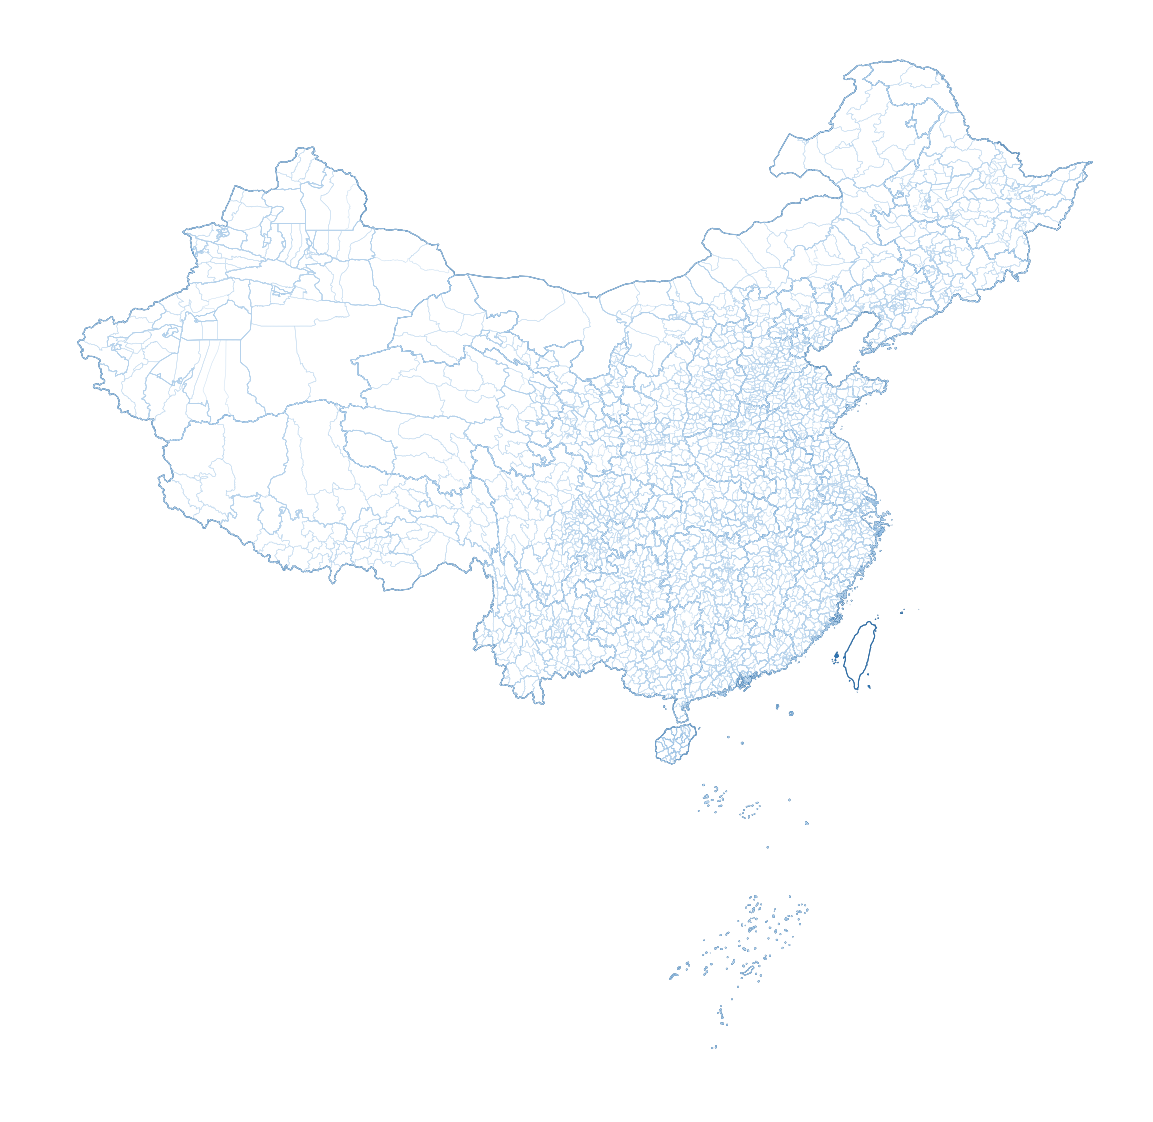

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
boundary[boundary.level=='country'].plot(ax=ax, color='',edgecolor=colors(30,78,121),linewidth=1)
boundary[boundary.level=='province'].plot(ax=ax, color='', edgecolor=colors(46,117,181),linewidth=0.8)
boundary[boundary.level=='city'].plot(ax=ax,color='',edgecolor=colors(156,195,229),linewidth=0.6)
boundary[boundary.level=='district'].plot(ax=ax,color='',edgecolor=colors(189,215,238),linewidth=0.4)
plt.axis('off')
plt.savefig(dpi=600,fname='C:\\Users\Administrator\Desktop\china.png')